In [1]:
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [13]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20170519/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20170519/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = '800669654264778-OBrother'
all_side_files_red = 'DoubleSpec/20170519/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20170519/blue*.fits'#BLUE side
target = fits.open('DoubleSpec/20170519/red0120.fits') #use these to get targetid
target[0].header
##################################################

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4141 / length of data axis 1                          
NAXIS2  =                  440 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBJECT  = '800669654264778-O

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


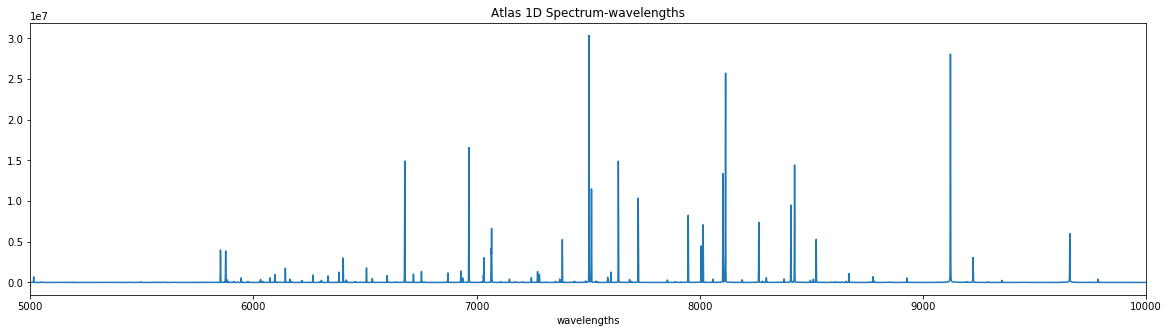

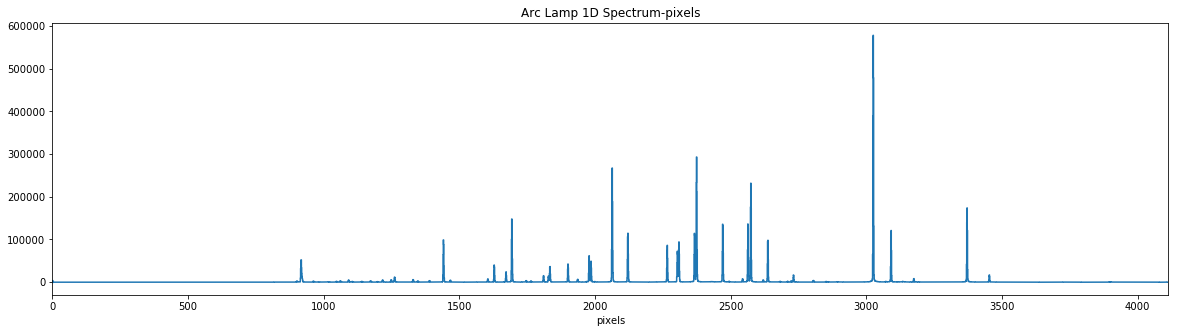

In [5]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

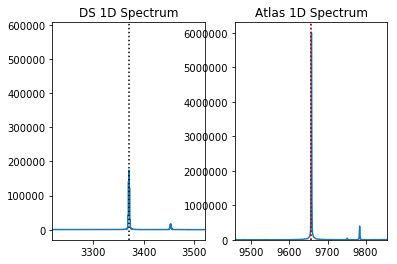

In [6]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(3370,9657,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [3024,2373,2062,1672,3370]
atlas_lines = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.2797688226410067, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.4990809349450942, which is less than 10"
Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 0.9648946538339258, which is less than 10"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.0205842020667832, which is less than 10"
Found line ArI at wl=7635.106
Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Guessed line's peak to base ratio is 0.9921479492029303, which is less than 10"
Failed to find line KrI at wl=7694.5393: "Tried to find peak at 2101.4523437501534 but it's in a valley, not a peak"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 1.5522857410999369, which is less than 10"
Failed to find line ArI at wl=7891.075: "Tried to find peak at 2228.7331172695303 but it's in a valley, not

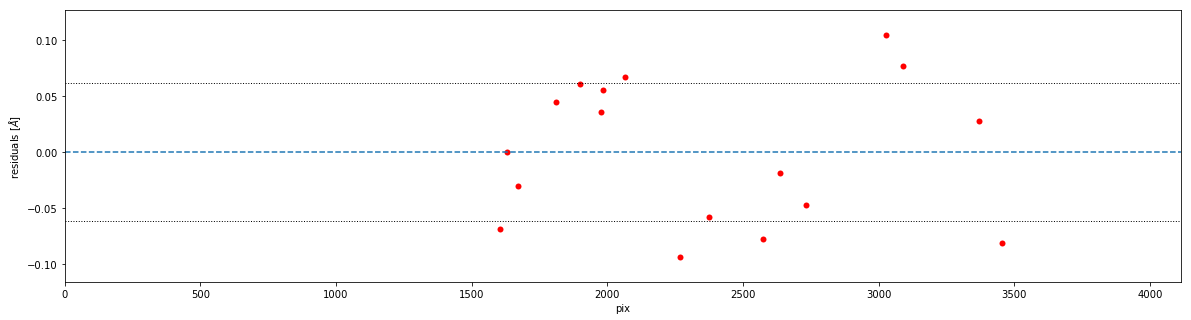

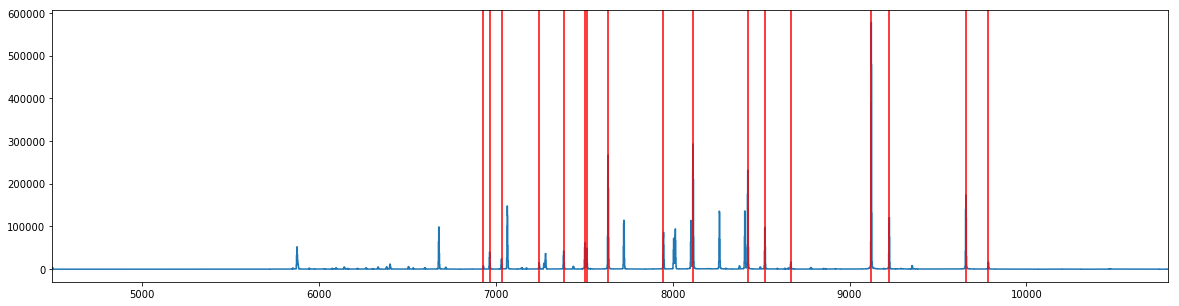

In [7]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


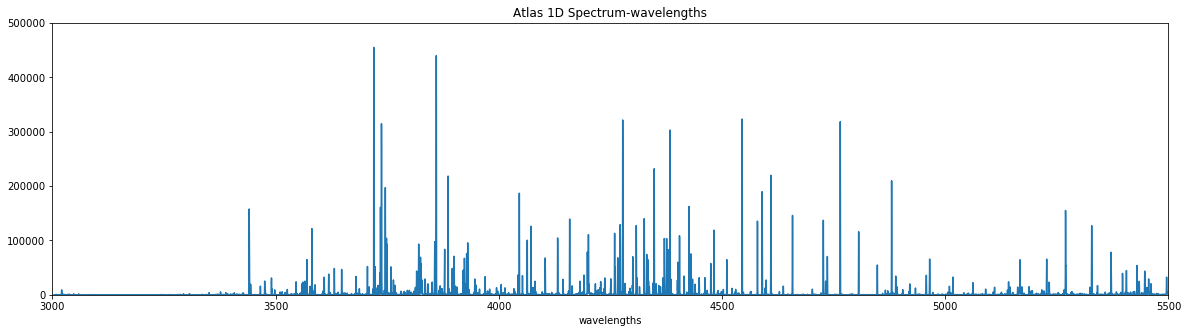

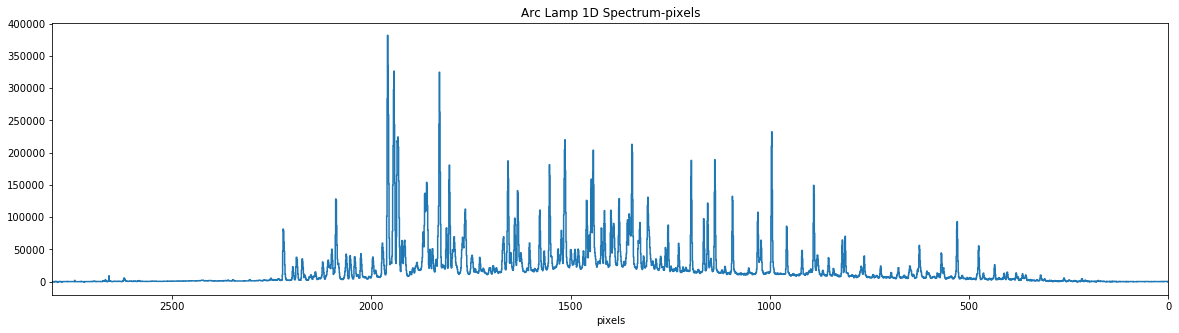

In [8]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

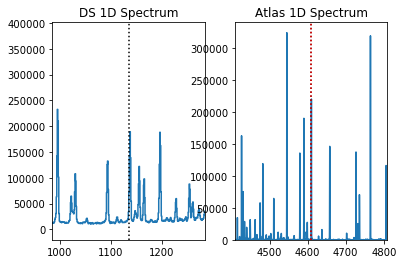

In [9]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [1956,1827,993,1029,528]#badvals 1135
atlas_lines = [3719.9346, 3859.9114, 4764.8646, 4726.8683, 5269.5366] #badvals 4609.5673
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

In [10]:
#creating a ds _ part three

ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside


ValueError: Tried to find peak at 1827 but it's in a valley, not a peak

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


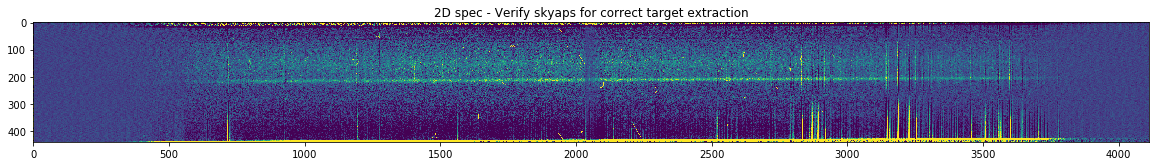

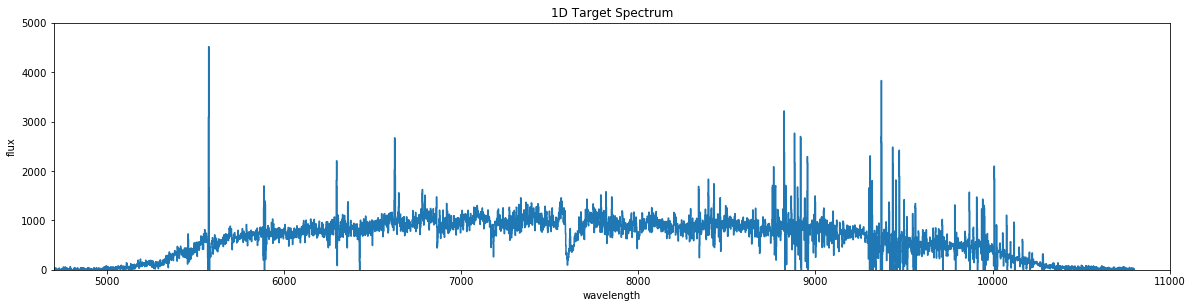

In [25]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red=[(30,105),(230,300)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (115,220)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??
#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

In [15]:
#BLUE side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_blue = [(130,190),(295,350)]#spatial regions above & below target to estimate sky emissions
model_blue = 'linear'#('poly',2) #estimating sky line tilt
specaps_blue = (271,306)#target spatial region
#####################################################
#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

NameError: name 'ds_blue' is not defined

In [16]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red
best_emission_skyaps = skyaps_red
best_emission_model = model_red
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (111, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


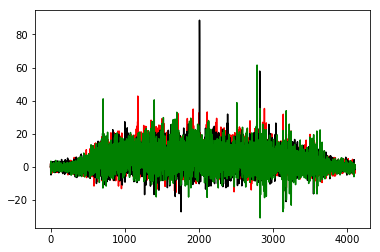

In [26]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(110,220) #target location
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[50],color='r')#near galaxy center
plt.plot(flux_data[20],color='k') #near galaxy edge
plt.plot(flux_data[75],color='g')#near opposite galaxy edge

#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

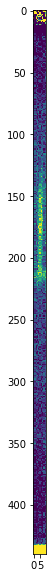

In [31]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################
testingthis=subimg2.data[:,1402:1412] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1402, 1412)
bestline_range_correction = (1392,1402) 
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

(1405, 1409)

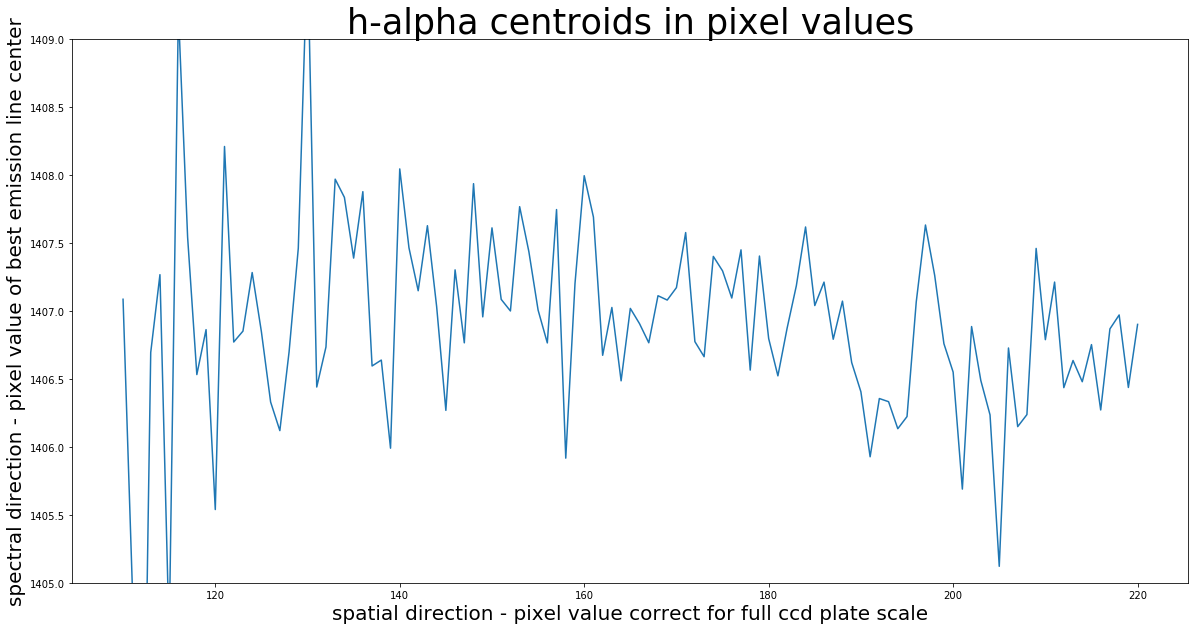

In [35]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0]))))
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1402:1412] #isolate wl around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1392:1402] #use 'bestline_range_correction' range
#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in flux_data_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_xs, centroid_ys = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################
plt.ylim(1405,1409)

In [34]:
#matrix fix if needed above

#takes out unc value from each matrix
#exploring means_unc problem/solution


print('10',type(means_unc[10]))

#determining which index of matrix value i want
print(np.shape(means_unc), 'MATRIX', means_unc[1],'SECOND ROW', means_unc[1][1], 'MIDDLE',means_unc[1][1][1])
print('possible problem matrix here',means_unc[10])

#setting up indexing array to explore all the matrices in for loop
matrix = np.arange(0,len(means_unc),1)
print('matrix length array', matrix)


badmatrix = np.array([ 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0])
badmatrix = np.reshape(badmatrix,(3,3))
print('shape',np.shape(badmatrix),'middle index',badmatrix[1][1])

unc = []
uncs = [] 
badvalues = []  
    
for i in matrix:
    #np.array([means_unc])
    #empty == type(np.any(means_unc[10])) #np.bool
    #print('empty',empty)
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i)
        badvalues.append(i)
        for j in badvalues:
            means_unc[j] = badmatrix
            ##uncs.append(means_unc[j][1][1])
            #print('one replaced uncs',uncs)
            #print('replaced with', means_unc[j])
            #print('right index?', means_unc[j][1][1])
            #print('replaced type',type(means_unc[j]))
    else:
        np.all(means_unc[i]) == np.all(means_unc[i])
        #print('reg type',type(means_unc[i]),'i=',i) #np.ndarray
    uncs.append(means_unc[i][1][1]) #does same as below
    #print('one original uncs',uncs)
    
unc.append(uncs) #does same as above
print('unc',np.shape(unc),len(unc),'uncs',np.shape(uncs),len(uncs))
print('uncs best b/c of shape but unc or uncs are both same array of middle term from matrices....ie sigma**2')
#print('unc len',len(unc),'unc shape',np.shape(unc),'unc',unc)

#print("another row", 'MATRIX', means_unc[51],'SECOND ROW', means_unc[51][1], 'MIDDLE',means_unc[51][1][1])
#print('maybe uncs is best',uncs,'shape',np.shape(uncs),'length',len(uncs))

print('use uncs for means_unc')

10 <class 'numpy.ndarray'>


TypeError: 'NoneType' object is not subscriptable